# Tutorial 2: Grid Localization

Welcome to week 2 of the tutorials. Last week we had a refresher course in working with python, this week we will be looking at grid localization.

## 1 - Packages

In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import copy

## 2 - Outline of the Tutorial

Robots encounter many uncertainties when operating in the real world. These uncertainties are contributed to from a number of factors, such as unpredictable environments, sensor limitations and robot actuations. For example, a robot moving through its environment will accumulate errors in odometry, gradually making it less certain of where it is.

A classic example of this problem is in robot localization, where a robot must estimate it's coordinates relative to an external reference frame. The robot is given a map of its environment, but in order to localize itself relative to this map it needs sensor input. Learning maps is a "chicken-and-egg" problem, for which it is often referred to as  *simultaneous localization and mapping (SLAM)*.
 
Some of the factors influencing the difficulty of a SLAM problem are:
* Size - The larger the environment relative to the robot’s perceptual range, the more difficult it is to acquire a map.
* Noise in perception and actuation - If robot sensors and actuators were noise-free, mapping would be a simple problem. The larger the noise, the more difficult the problem.
* Perceptual ambiguity - The more frequently different places look alike, the more difficult it is to establish correspondence between different locations traversed at different points in time.

### 2.1 - Grid Map

Localization is a key problem in robotics and is often filled with uncertainties. Grid localization uses a histogram filter to update the *belief*. Histogram filters decompose the state space into finitely many regions and represents each region as a single probability. The probabilistic paradigm represents the robot’s
momentary belief by a probability density function over the space of all locations i.e. grid cells. Formally, the belief, $bel(x_t)$ is the estimate of the robot's position in space, $x_t$ at a given time, $t$. This can be summarized by the equation below:

$bel(x_t)$ = {$p_{k,t}$}

Where {$p_{k,t}$} is the set of probabilities over a robot positions $x_k$ at time, $t$. For grid localization, we decompose the position into discrete cells.  In the example below, we can see the map which has been discretized into a (3 x 6) matrix. 

<img src="images/grid.png">

### 2.2 - Grid Map with Beliefs

The grid map below shows the belief or probability distribution that the robot is in a particular cell, with the more saturated color indicating a higher probability. 
Therefore, {$p_{k,t}$} is the probability of being in each cell within a grid map.

<img src="images/grid_heat_map.png">

### 2.3 - Sensing and Action

The image below shows the iterative process by which the robot 'moves' and 'senses'. The robot gains a better understanding of where it is in the world as more of these iterations are completed.

<img src="images/sense_move_act.png">

**Actions:** 
* Actions are denoted $u_t$.
* The agent can move one square up, down, left or right.
* The agent cannot move out of the grid.
* Occasionally, the agent fails to move to the desired location. This occurs with a given probability, *actionFailsProb*, summarized formally in the motion model equation: $ p(x_{k, t+1}$ | $ x_{k, t}, u_t $). Where $x_{k, t+1}$ is the probability distribution for positons in the next time step after an action $u_t$.


**Sensing:**
* Measurements are denoted $z_t$.
* Here, we assume that each location in the grid is either 'free' or 'occupied'.  
* The agent can sense if there is a cow in a cell with a given probability, *senseFailsProb*. This is expressed formally by the measurement model $ p(z_t$ | $ x_{k, t}) $. Where the proability of measuring $z_t$ given the current probabilities of being in a particular cell, $x_{k, t}$.

### 2.4 - Occupancy Grid

<img src="images/grid_cows.png">

## 3 - Define World

In [26]:
class GridWorld(object):
    """
    Gridworld object defines how the robot senses and moves within
    the grid map
    """
    def __init__(self):
        """
        Initializes robot occupancy map, current position/state, action failure
        probability and sensor failure possibility
        
        Arguments:
        self.occupancyMap -- map of the occupancy grid in the image above. 3x6
        numpy array showing occupied cells
        self.map -- map showing the current position of the robot in the map
        self.state -- current position of the robot within the grid map. [x,y]
        self.actionFailsProb -- probability the action fails 
        self.state -- probability the sensor fails
        """
        self.map = np.zeros((3,6),dtype=bool)
        
        self.occupancyMap = self.map
        self.occupancyMap = np.array([[1,1,0,0,0,1],
                                      [0,0,1,1,0,1],
                                      [0,0,1,0,1,0]], dtype=bool)
        
        self.state = np.array([1 , 0])
        self.actionFailsProb = 0.1
        self.senseFailsProb = 0.1
        
    def step(self, action):
        """
        Defines the rules for moving within the grid
        
        Arguments:
        self -- (1, 2) numpy array of the robot's current position in the grid
        action -- the direction for the robot to move e.g. "r" for right
        
        Returns:
        updates self.state after the action
        """
        actionFails = np.random.rand() < self.actionFailsProb
        
        if actionFails:
            pass
        else:
            if action == "r":
                self.state[1] = np.minimum(self.state[1] + 1,  self.map.shape[1] - 1)
            elif action == "l":
                self.state[1] = np.maximum(self.state[1] - 1, 0)
            # Implement the action steps for up and down actions
            ### START CODE HERE ### (≈ 4 lines of code)
            elif action == "d":
                self.state[0] = np.minimum(self.state[0] + 1,  self.map.shape[0] - 1)
            elif action == "u":
                self.state[0] = np.maximum(self.state[0] - 1, 0)
            ### END CODE HERE ###
                
    def sense(self):
        """
        Defines the rules for sensing with a probability the sensor fails
        """
        
        # Implement the probability the sensor fails
        ### START CODE HERE ### (≈ 1 line of code)
        senseFails = np.random.rand() < self.senseFailsProb
        ### END CODE HERE ###
        
        trueSense = self.occupancyMap[self.state[0], self.state[1]]
        if senseFails:
            return not(trueSense)
        else:
            return trueSense
        

Initial position: 

[1 0]


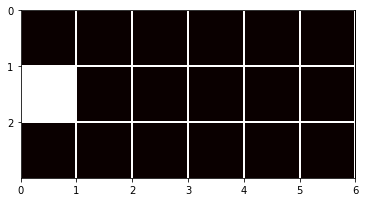

Final position: 

[1 3]


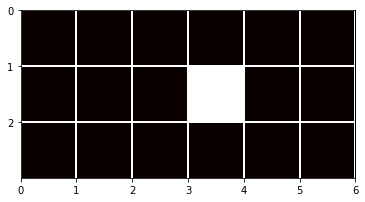

In [27]:
# Test the step function

worldTest = GridWorld()
positionMap = copy.copy(worldTest.map)
positionMap[worldTest.state[0],worldTest.state[1]] = 1

print("Initial position: \n")
print(worldTest.state)

# Plotting the initial position on map
ax = plt.gca()
ax.set_yticks(np.arange(0, 3, 1));
extent = (0, positionMap.shape[1], positionMap.shape[0], 0)
plt.imshow(positionMap, extent=extent, cmap='hot')
plt.grid(color='w', linestyle='-', linewidth=2)
plt.show()

# Move the robot from initial position [1, 0] to [0, 3]
### START CODE HERE ### (≈ 4 lines of code)
worldTest.step("r")
worldTest.step("r")
worldTest.step("r")
worldTest.step("u")
### END CODE HERE ### 

print("Final position: \n")
print(worldTest.state)

positionMap = copy.copy(worldTest.map)
positionMap[worldTest.state[0],worldTest.state[1]] = 1

# Plotting the final position on map
ax = plt.gca()
ax.set_yticks(np.arange(0, 3, 1));
extent = (0, positionMap.shape[1], positionMap.shape[0], 0)
plt.imshow(positionMap, extent=extent, cmap='hot')
plt.grid(color='w', linestyle='-', linewidth=2)
plt.show()

In [28]:
class StateEstimator(object):
    """
    Contains the methods required to update the belief based on the 
    probability the action or sensor fails
    
    """
    def __init__(self, world):
        """
        Initializes the object, selecting either the occupancy map or grid map          
        """
        
        self.actionFailsProb = world.actionFailsProb
        self.senseFailsProb = world.senseFailsProb
        
        # Using the occupancy map         
        self.map = world.occupancyMap
        
        # Initialize belief matrix, normalized and equal probability for each cell
        self.belief = np.ones(world.map.shape)/np.prod(world.map.shape) 
        
    def actionUpdate(self, action):
        """
        Calculates the new belief for each action based on the probability the action might fail
        
        Variables:
        self.belief -- belief from the previous time step
        newBelief -- updated belief
        action -- string which states the direction the robot moves
        """
        
        newBelief = np.zeros(self.belief.shape, dtype=float)
        
        if action == "r":
            # New belief for column 0 is the old belief * the probability action has failed.
            newBelief[:, 0] = self.belief[:,0]*self.actionFailsProb 
            
            # New belief for columns 1-4 is the old belief * the probability the previous action 
            # failed (and the robot is still in columns 1-4) + old belief * the probability the 
            # previous action didn't fail and robot was in columns 0-3.
            newBelief[:, 1:-1] = (self.belief[:, 1:-1]*self.actionFailsProb + 
                                  self.belief[:, 0:-2]*(1-self.actionFailsProb))
            
            # New belief for column 5 is the old belief * the probability the robot was in this cell 
            # in the last time step and successfully moved right, leaving the robot back in the same 
            # position (hence probability of one) + the old belief * the probability the robot was in 
            # column 4 in the previous time step (meaning previous action didn't fail)
            newBelief[:, -1] = (self.belief[:,-1]*1 + 
                                self.belief[:, -2]*(1-self.actionFailsProb))
            
            # Updating self.belief to the newBelief
            self.belief = newBelief
            
        if action == "l":
            newBelief[:, -1] = self.belief[:,-1]*self.actionFailsProb 

            newBelief[:, 1:-1] = (self.belief[:, 1:-1]*self.actionFailsProb + 
                                  self.belief[:, 2:]*(1-self.actionFailsProb))

            newBelief[:, 0] = (self.belief[:,0]*1 + 
                               self.belief[:, 1]*(1-self.actionFailsProb))
            
            self.belief = newBelief
        
        if action == "u":
            newBelief[-1, :] = self.belief[-1,:]*self.actionFailsProb
                       
            newBelief[1,:] = (self.belief[1,:]*self.actionFailsProb + 
                              self.belief[-1,:]*(1-self.actionFailsProb))
           
            newBelief[0, :] = self.belief[0,:]*1 + self.belief[1,:]*(1-self.actionFailsProb)
 
            self.belief = newBelief
            
        if action == "d":

            newBelief[0, :] = self.belief[0,:]*self.actionFailsProb
                       
            newBelief[1,:] = (self.belief[1,:]*self.actionFailsProb + 
                              self.belief[0,:]*(1-self.actionFailsProb))
           
            newBelief[-1, :] = self.belief[-1,:]*1 + self.belief[1,:]*(1-self.actionFailsProb)
        
            self.belief = newBelief
                
    def measurementUpdate(self, measurement):
        """
        Updates the measurement based on Bayes' filter
        
        Variables:
        prior -- previous belief
        posterior -- new belief
        measurement -- the most recent measurement
        """
        
        prior = self.belief
        likelihood = (self.senseFailsProb*np.not_equal(measurement, self.map, dtype=int) +
                      (1 - self.senseFailsProb)*np.equal(measurement, self.map, dtype=int))
        posterior = prior*likelihood
        marginal = np.sum(posterior)
        self.belief = posterior/marginal

## 3 - Main Loop

In [29]:
def main():
    world = GridWorld()
    estimator = StateEstimator(world)
    
    # Using the occupancy map, move the robot right 3, down 1, and left 1
    ### START CODE HERE ### (~1 line of code)
    for indexAction,action in enumerate(["r"]*3 + ["d"] + ["l"]):
    ### END CODE HERE ###
        measurement = world.sense()
        estimator.measurementUpdate(measurement)
        
        world.step(action)
        estimator.actionUpdate(action)
        
        print("Estimate after move %d:" % (indexAction+1))
        print("\n")
        ax = plt.gca()
        ax.set_yticks(np.arange(0, 3, 1));
        extent = (0, positionMap.shape[1], positionMap.shape[0], 0)
        plt.imshow(estimator.belief, extent=extent,cmap='binary', interpolation='nearest')
        plt.grid(color='w', linestyle='-', linewidth=2)
        plt.show()
        print(estimator.belief)
        print("\n")
        
    print("Sum of the probabilities:\n")
    
    # Show that the sum of the estimates is equal to 1
    ### START CODE HERE ### (≈ 1 line of code)
    print(np.sum(estimator.belief))
    ### END CODE HERE ###

Estimate after move 1:




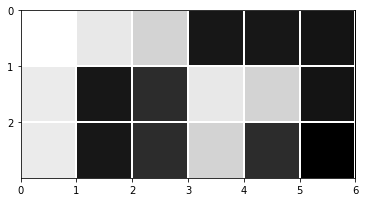

[[0.001 0.01  0.018 0.092 0.092 0.093]
 [0.009 0.092 0.084 0.01  0.018 0.093]
 [0.009 0.092 0.084 0.018 0.084 0.101]]


Estimate after move 2:




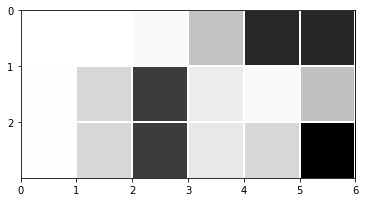

[[1.913e-05 3.634e-04 4.820e-03 4.338e-02 1.549e-01 1.568e-01]
 [1.549e-03 2.944e-02 1.410e-01 1.431e-02 4.820e-03 4.529e-02]
 [1.549e-03 2.944e-02 1.410e-01 1.721e-02 2.946e-02 1.845e-01]]


Estimate after move 3:




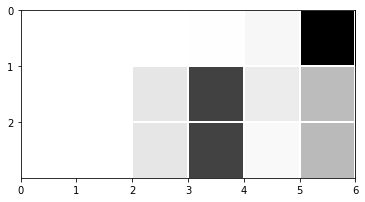

[[3.294e-06 9.223e-05 6.555e-04 1.660e-03 1.043e-02 2.968e-01]
 [2.964e-05 8.300e-04 2.935e-02 2.210e-01 2.227e-02 7.883e-02]
 [2.964e-05 8.300e-04 2.935e-02 2.189e-01 8.037e-03 8.096e-02]]


Estimate after move 4:




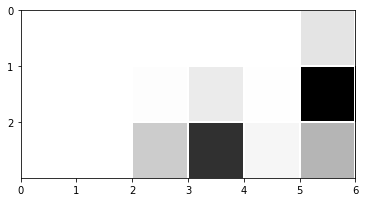

[[4.700e-07 1.316e-05 1.039e-05 2.632e-05 1.654e-04 4.235e-02]
 [4.700e-06 1.316e-04 4.282e-03 3.177e-02 1.842e-03 3.924e-01]
 [8.930e-06 2.500e-04 7.957e-02 3.185e-01 1.464e-02 1.141e-01]]


Estimate after move 5:




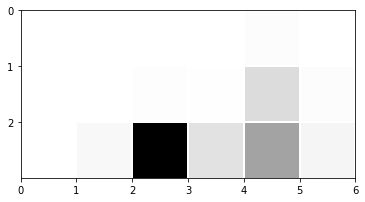

[[2.749e-06 1.908e-05 4.967e-05 3.044e-04 8.540e-03 9.452e-04]
 [2.474e-04 8.866e-04 6.478e-03 4.039e-03 7.919e-02 8.758e-03]
 [4.700e-04 1.604e-02 5.776e-01 6.693e-02 2.066e-01 2.291e-02]]


Sum of the probabilities:

1.0


In [30]:
main()

**Tasks to complete:**
* Try changing the probabilities the sensor and action fails, how does this affect the robot's understanding of where it is?
* In the __init__ function in the StateEstimator class, try changing from the occupancy map to the grid map. How does this change the robot's understanding of where it is?


**References:**

Thrun, S., Burgard, W. and Fox, D., 2005. Probabilistic robotics. MIT press.